Для временного ряда bike-sharing построить три модели:
* Датасет аггрегировать по неделям
* Простое экспоненциальное сглаживание
* Двойное экспоненциальное сглаживание
* Тройное экспоненциальное сглаживание (тип модели additive или multiplicative) выбрать самостоятельно 


Для финального отчета сделать кросс-валидацию, пояснить выбранные метрики, а так же их финальные значения. 





In [332]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from plotly.graph_objects import *
from plotly.offline import init_notebook_mode,iplot
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('../datatest/bike-sharing.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,9.84,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,9.02,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,9.02,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,9.84,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,9.84,0.2879,0.75,0.0,0,1,1


In [333]:
df = df[['dteday','cnt']]
df['dteday'] = pd.to_datetime(df['dteday'])

# Агрегация по неделям

In [334]:
df.set_index('dteday',inplace=True)
df_agg = df.resample('W').mean()
df_agg.rename(columns = {'cnt' : 'mean'}, inplace = True) # Агрегируем по среднему значению

df_agg.head()

,mean
dteday,
2011-01-02,38.000000
2011-01-09,58.074074
2011-01-16,55.368098
2011-01-23,57.320261
2011-01-30,55.388489


In [335]:
len_df = len(df_agg.index)-1

# Сезонность

<AxesSubplot:xlabel='dteday'>

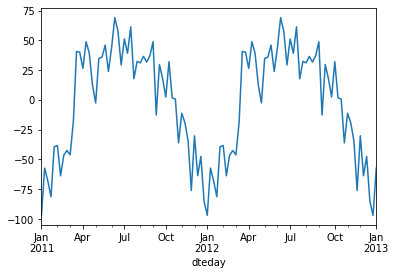

In [336]:
result = seasonal_decompose(df_agg, model='additive')
result.seasonal.plot()

Сезонность составляет ровно год или 52 недели.

# Простое экспоненциальное сглаживание

In [314]:
df_agg['ses'] = SimpleExpSmoothing(df_agg['mean']).fit(smoothing_level = 1/7,
                                                       optimized = False,use_brute = True).fittedvalues

In [315]:
iplot(Figure(data=[Scatter(x = df_agg.index,
                          y = df_agg['mean'],
                          name = 'Original'),
                  Scatter(x = df_agg.index,
                         y = df_agg['ses'],
                         name = 'Simple Exponential Smoothing')]))

# Двойное экспоненциальное сглаживание

In [316]:
df_agg['des_mul']=ExponentialSmoothing(df_agg['mean'], trend='mul').fit().fittedvalues


iplot(Figure(data=[Scatter(x =df_agg.index,
                          y = df_agg['mean'],
                          name = 'Original'),
                  Scatter(x = df_agg.index,
                         y = df_agg['des_mul'],
                         name = 'Double Exponential Smoothing (Multiplicative)')]))

# Тройное экспоненциальное сглаживание

In [337]:
df_agg['tes_mul'] = ExponentialSmoothing(df_agg['mean'], 
                                         trend = 'mul', 
                                         seasonal = 'mul', 
                                         seasonal_periods = 52).fit().fittedvalues

iplot(Figure(data = [Scatter(x =df_agg.index,
                          y = df_agg['mean'],
                          name = 'Original'),
                 
                  Scatter(x = df_agg.index,
                         y = df_agg['tes_mul'],
                         name = 'Tripple Exponential Smoothing (Multiplicative)')]))

# Кроссвалидация

In [338]:
size_train = int(len(df_agg)*0.8)
train, test = df_agg[0:size_train], df_agg[size_train:]
mod = ExponentialSmoothing(train['mean'], 
                           trend = 'mul', 
                           seasonal_periods = 52, 
                           seasonal = 'mul' 
                           ).fit()

In [339]:
len(df_agg)

106

In [340]:
mod.summary()

Dep. Variable:,mean,No. Observations:,84
Model:,ExponentialSmoothing,SSE,7082.298
Optimized:,True,AIC,484.501
Trend:,Multiplicative,BIC,620.627
Seasonal:,Multiplicative,AICC,758.261
Seasonal Periods:,52,Date:,"Wed, 15 Dec 2021"
Box-Cox:,False,Time:,02:41:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9999998,alpha,True
smoothing_trend,1.8958e-07,beta,True


In [343]:
preds = mod.forecast(len(test))

In [344]:
trace1 = Scatter(x = test.index, y = test['mean'], name = 'Original')
trace2 = Scatter(x = test.index,y = preds, name = 'Exponential Smoothing')
iplot(Figure(data = [trace1, trace2]))